In [33]:
import torch
import debayer
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams["figure.figsize"]=20,20

In [ ]:
!pip3 install -U git+https://github.com/cheind/pytorch-debayer --force -q
!pip3 install torch -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [22]:
def plot_kernel(k, ax=None):
  ax = ax or plt.gca()
  return ax.imshow(k, interpolation="nearest")


def reconstruct_kernel(k, n:int=None, min_score:float=None):
  n = n or k.shape[0]
  min_score = min_score or 1.0
  u,s,vt = torch.linalg.svd(k, full_matrices=True)
  kr = torch.zeros_like(k)
  score = 0.0
  for i in range(n):  
    kr = kr + u[:,i:i+1]*s[i]*vt[i:i+1,:]
    # print(u[:, i])
    # print(vt[i, :])
    # print(s[i])
    score += abs(s[i])
    if score/s.abs().sum() >= min_score:
      break
  print(f'Used {i+1} singular vector(s), score {score/s.abs().sum()*100:.3f}%')
  return kr

Used 2 singular vector(s), score 100.000%
Used 2 singular vector(s), score 98.105%
Used 2 singular vector(s), score 98.105%
Used 2 singular vector(s), score 94.059%


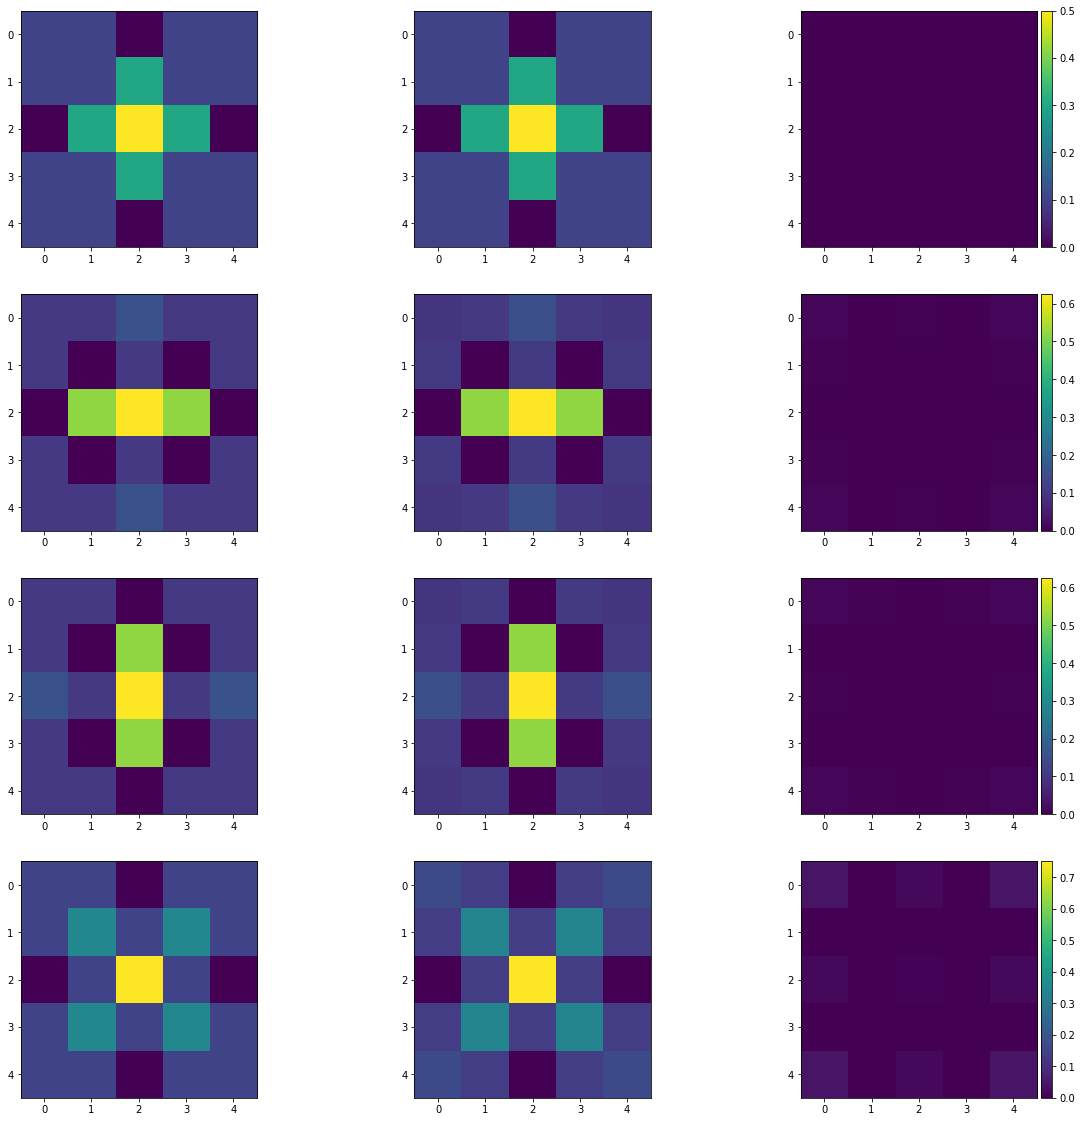

In [40]:
kernels = debayer.Debayer5x5().kernels.data
fig, axs = plt.subplots(4,3)

for idx in range(kernels.shape[0]):
  k = kernels[idx,0]
  kr = reconstruct_kernel(k, min_score=0.9) 
  diff = abs(k-kr)
  plot_kernel(k, axs[idx,0])
  plot_kernel(kr, axs[idx,1])
  data = axs[idx,2].imshow(diff, vmin=0, vmax=k.max())

  div = make_axes_locatable(axs[idx,2])
  cax = div.append_axes('right', size='5%', pad=0.05)
  fig.colorbar(data, cax=cax, orientation='vertical')

In [38]:
from debayer.apps.utils import read_image

def run(min_score:float):
    # Patch module
    dapprox = debayer.Debayer5x5()
    for idx in range(dapprox.kernels.shape[0]):
        dapprox.kernels.data[idx, 0] = reconstruct_kernel(dapprox.kernels.data[idx, 0], min_score=min_score).float()
    dapprox = dapprox.cuda()
    dexact = debayer.Debayer5x5().cuda()

    input_image, b = read_image(r"D:\PhotoCD_PCD0992\23.png", bayer=False)
    t = torch.tensor(b).float().unsqueeze(0).unsqueeze(0).cuda() / 255.0
    rgb_approx = dapprox(t)
    rgb_exact = dexact(t)

    rgb_orig = torch.tensor(input_image).permute(2,0,1).float().cuda().unsqueeze(0) / 255.0

    print(debayer.metrics.peak_signal_noise_ratio(rgb_orig, rgb_exact, datarange=1)[0].mean())
    print(debayer.metrics.peak_signal_noise_ratio(rgb_orig, rgb_approx, datarange=1)[0].mean())

    rgb_approx = rgb_approx.squeeze().permute(1, 2, 0).cpu().to(torch.float32)
    rgb_exact = rgb_exact.squeeze().permute(1, 2, 0).cpu().to(torch.float32)
    rgb_orig = rgb_orig.squeeze().permute(1, 2, 0).cpu().to(torch.float32)


    fig, axs = plt.subplots(1,2)
    div = make_axes_locatable(axs[1])
    cax = div.append_axes('right', size='5%', pad=0.05)
    axs[0].imshow(rgb_approx)
    im = axs[1].imshow(np.abs(rgb_orig-rgb_approx), vmin=0, vmax=1)
    fig.colorbar(im, cax=cax, orientation='vertical')

Used 1 singular vector(s), score 76.726%
Used 1 singular vector(s), score 83.002%
Used 1 singular vector(s), score 83.002%
Used 1 singular vector(s), score 58.812%
tensor(38.3650, device='cuda:0')
tensor(18.5109, device='cuda:0')
Used 2 singular vector(s), score 100.000%
Used 2 singular vector(s), score 98.105%
Used 2 singular vector(s), score 98.105%
Used 2 singular vector(s), score 94.059%
tensor(38.3650, device='cuda:0')
tensor(30.9930, device='cuda:0')
Used 2 singular vector(s), score 100.000%
Used 3 singular vector(s), score 100.000%
Used 3 singular vector(s), score 100.000%
Used 3 singular vector(s), score 100.000%
tensor(38.3650, device='cuda:0')
tensor(38.3650, device='cuda:0')


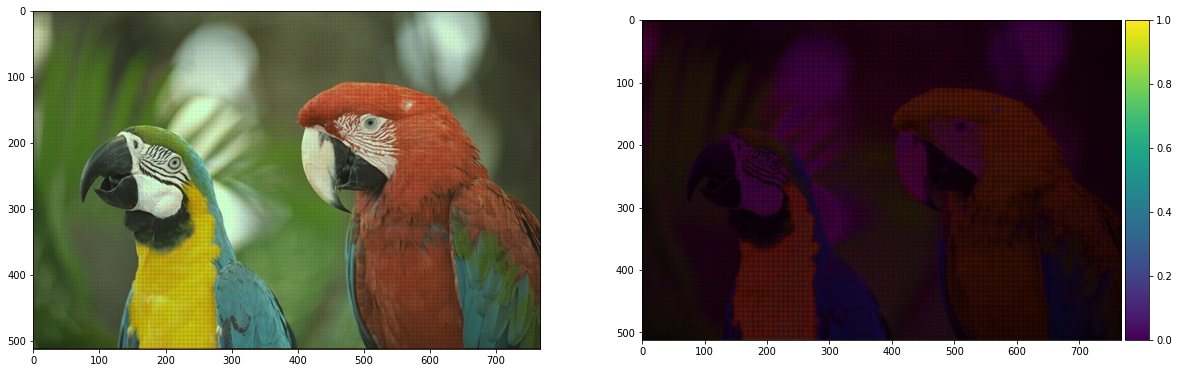

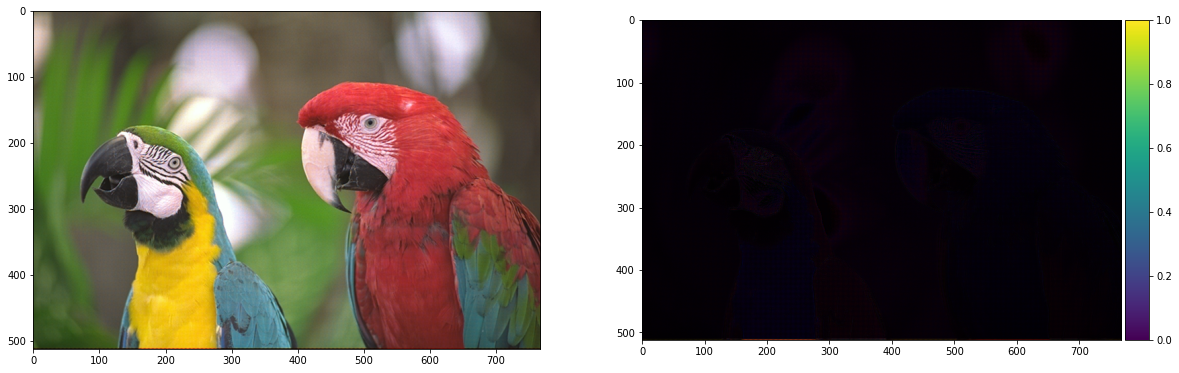

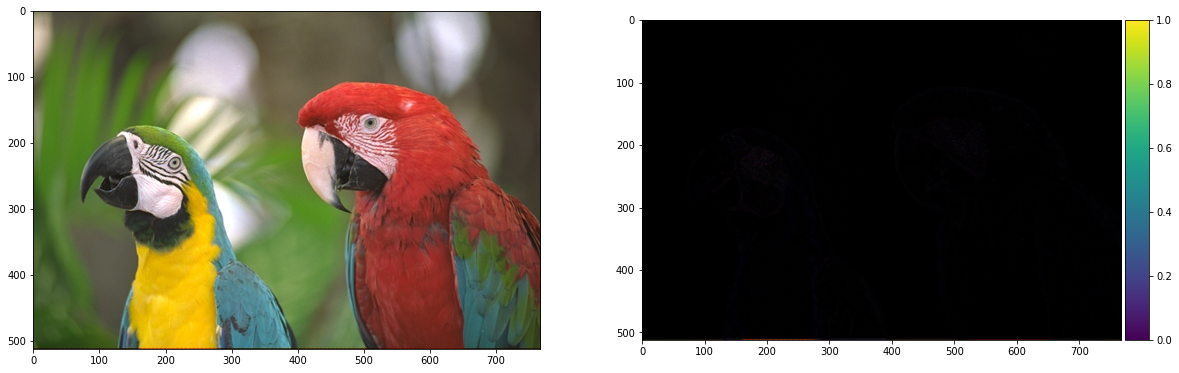

In [39]:
run(0.5)
run(0.9)
run(0.99)